# Implementation: Medium Design a Movie Recommendation System with using Graph Database (neo4j) — part 1

- link:https://medium.com/@yesilliali/design-a-movie-recommendation-system-with-using-graph-database-neo4j-part-1-2c4933f4da0a

## preview data 

In [1]:
import os 
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
os.listdir('./data')

['links.csv',
 'tags.csv',
 'genome-tags.csv',
 'ratings.csv',
 'README.txt',
 'genome-scores.csv',
 'movies.csv']

In [3]:
tag_df = pd.read_csv('./data/genome-scores.csv') 
movie_df = pd.read_csv('./data/movies.csv') 
rating_df = pd.read_csv('./data/ratings.csv')

In [4]:
tag_df.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [5]:
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
rating_df.head(3)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828


In [7]:
# how many users and movies?
print('user unique:',rating_df['userId'].nunique())
print('movie unique:',rating_df['movieId'].nunique())

user unique: 162541
movie unique: 59047


In [8]:
'''
依照原本的方法，在計算 cos similarity 的時候，會需要耗用大量的 RAM
因為他是一個稀疏矩陣，當有 N 個電影，就會創立 N*N 大小的矩陣
那這次實驗先縮小 movie 數量嘗試看看
'''

# limit to 1000 movies
movieId_list = movie_df['movieId'].sample(1000)

tag_df = tag_df[tag_df['movieId'].isin(movieId_list)]
movie_df = movie_df[movie_df['movieId'].isin(movieId_list)]
rating_df = rating_df[rating_df['movieId'].isin(movieId_list)]

print(tag_df.shape
      ,movie_df.shape
      ,rating_df.shape)

(266208, 3) (1000, 3) (365615, 4)


## preprocess for movie matrix

### genome_scores

-  For each `movieId`, there is a corresponding `relevance` value for each `tagId`, with a total of 1,128 `tagId`s.
- The current format shows one `movieId` and one `tagId` per row. We need to transform it so each row represents one `movieId` with relevance values for all 1,128 `tagId`s.

In [9]:
tag_df = tag_df.pivot(index=['movieId'], columns=['tagId'], values='relevance').reset_index()

# scores_pivot = genome_scores_data.pivot_table(index = ["movieId"],columns = ["tagId"],values = "relevance").reset_index()


In [10]:
tag_df

tagId,movieId,1,2,3,4,5,6,7,8,9,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
0,63,0.05325,0.05275,0.02325,0.03825,0.07150,0.05575,0.06150,0.13400,0.03750,...,0.08750,0.01750,0.00775,0.02275,0.19000,0.03200,0.02925,0.00875,0.08650,0.01625
1,103,0.03425,0.04075,0.02075,0.03650,0.05700,0.02050,0.02550,0.10050,0.02675,...,0.03475,0.02075,0.01225,0.03000,0.15850,0.05175,0.01800,0.01125,0.08700,0.01675
2,131,0.01775,0.02000,0.10725,0.09325,0.11000,0.06725,0.02975,0.11350,0.07125,...,0.08375,0.01925,0.01350,0.10400,0.28650,0.03900,0.02875,0.05925,0.11725,0.02200
3,167,0.01725,0.02000,0.11425,0.20550,0.18850,0.01750,0.03175,0.15550,0.02325,...,0.03550,0.02925,0.01700,0.12150,0.14750,0.05700,0.08800,0.00875,0.07225,0.01600
4,178,0.02500,0.02825,0.03750,0.04025,0.07100,0.02500,0.02650,0.13375,0.03325,...,0.08000,0.02275,0.01825,0.06575,0.33400,0.06750,0.04125,0.01075,0.09325,0.01950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,195777,0.05400,0.04775,0.05700,0.06250,0.08525,0.02600,0.03075,0.10950,0.05200,...,0.06475,0.03375,0.02075,0.02300,0.19325,0.07475,0.04600,0.01625,0.18100,0.03300
232,196487,0.04375,0.03775,0.03175,0.06475,0.04675,0.01625,0.03475,0.05075,0.04900,...,0.04550,0.06350,0.01200,0.03175,0.17050,0.13925,0.07225,0.01000,0.11875,0.02725
233,197175,0.05350,0.04375,0.05475,0.10800,0.10875,0.05600,0.06525,0.23300,0.08125,...,0.11700,0.03925,0.02150,0.02750,0.14925,0.13925,0.06025,0.01975,0.12800,0.03475
234,198147,0.03025,0.02450,0.06725,0.09425,0.03725,0.01675,0.04650,0.05075,0.01800,...,0.04225,0.02625,0.01075,0.06600,0.27400,0.05650,0.01300,0.01025,0.15900,0.04100


In [11]:
'''
補那些沒有在裡面的 movieiId, tag 關係度都設置為 0
'''
missing_movieId_list = list(set(movieId_list)-set(tag_df['movieId'].tolist()))

column_names = list(range(1, 1129))
new_rows = pd.DataFrame(
    data=[[0] * len(column_names)] * len(missing_movieId_list), 
    index=missing_movieId_list,  
    columns=column_names )

tag_df = pd.concat([tag_df, new_rows])

### movies_data 

- process genres col, transfrom it to each row represents a single `movieId`, and the columns represent the `genres`. 

In [12]:
caculate_genres_df = movie_df['genres'].str.get_dummies(sep='|')
caculate_genres_df.insert(0, 'movieId', movie_df['movieId'])
caculate_genres_df.drop(columns=['(no genres listed)'])
caculate_genres_df.head()


,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
62,63,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
101,103,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
129,131,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
165,167,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
176,178,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### ratings_data

- first, extract the year from `title`, but note that some titles do not include parentheses and a year.

In [13]:
print(rating_df.head(1))
print(movie_df.head(1))

    userId  movieId  rating   timestamp
53       1     7939     2.5  1147869183
    movieId                                              title        genres
62       63  Don't Be a Menace to South Central While Drink...  Comedy|Crime


In [14]:
title_list = movie_df['title'].tolist()

for i in title_list:
    if not '(' in i:
        print(i)

Hyena Road
A Fare to Remember
Holy Hell
Digital Dharma
Ulvova Mylläri
Sequence Break
Going for Broke
Rooster: Spurs of Death!
Anthony Joshua: The Road to Klitschko
Derrick J's Victimless Crime Spree
Nakimushi Shottan no Kiseki
Peshavarskiy vals


In [15]:
def get_title_year(x):
    if '(' in x and ')' in x:
        if (x.split('(')[1])[0:4].isdigit():
            return (x.split('(')[1])[0:4]
        else:
            return np.nan
    else:
        return np.nan

caculate_movie_year_df = movie_df.copy()
caculate_movie_year_df['title_year'] = movie_df['title'].apply(lambda x: get_title_year(x) )


In [16]:
caculate_movie_year_df

,movieId,title,genres,title_year
62,63,Don't Be a Menace to South Central While Drink...,Comedy|Crime,1996
101,103,Unforgettable (1996),Mystery|Sci-Fi|Thriller,1996
129,131,Frankie Starlight (1995),Drama|Romance,1995
165,167,Feast of July (1995),Drama,1995
176,178,Love & Human Remains (1993),Comedy|Drama,1993
...,...,...,...,...
61853,207093,Walt Disney (2015),Documentary,2015
61883,207167,Fragmentos de una amiga desconocida (2019),Documentary,2019
61970,207417,Mary (2019),Drama|Horror,2019
62168,208152,Ghost Tropic (2019),(no genres listed),2019


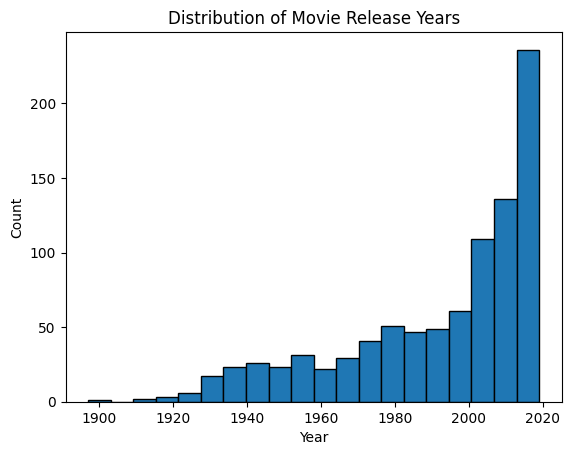

In [17]:
caculate_movie_year_df['title_year'] = pd.to_numeric(caculate_movie_year_df['title_year'], errors='coerce')

caculate_movie_year_df['title_year'].dropna().plot(
    kind='hist',
    bins=20,   
    edgecolor='black',
    title='Distribution of Movie Release Years'
)

plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [18]:
print(caculate_movie_year_df['title_year'].min())
print(caculate_movie_year_df['title_year'].max())
print(caculate_movie_year_df['title_year'].median())



1897.0
2019.0
2002.0


In [19]:
num_bins = 5 
bins = np.linspace(caculate_movie_year_df['title_year'].min(), caculate_movie_year_df['title_year'].max(), num_bins + 1)
caculate_movie_year_df['year_group'] = pd.cut(caculate_movie_year_df['title_year'], bins=bins, labels=range(1, num_bins + 1))
caculate_movie_year_df['year_group'] = caculate_movie_year_df['year_group'].cat.add_categories([0]).fillna(0)
caculate_movie_year_df.head(10)

,movieId,title,genres,title_year,year_group
62,63,Don't Be a Menace to South Central While Drink...,Comedy|Crime,1996.0,5
101,103,Unforgettable (1996),Mystery|Sci-Fi|Thriller,1996.0,5
129,131,Frankie Starlight (1995),Drama|Romance,1995.0,5
165,167,Feast of July (1995),Drama,1995.0,5
176,178,Love & Human Remains (1993),Comedy|Drama,1993.0,4
198,200,"Tie That Binds, The (1995)",Thriller,1995.0,5
222,225,Disclosure (1994),Drama|Thriller,1994.0,4
229,232,Eat Drink Man Woman (Yin shi nan nu) (1994),Comedy|Drama|Romance,NaN,0
255,258,"Kid in King Arthur's Court, A (1995)",Adventure|Children|Comedy|Fantasy|Romance,1995.0,5
421,426,Body Snatchers (1993),Horror|Sci-Fi|Thriller,1993.0,4


In [20]:
caculate_movie_year_df[caculate_movie_year_df['title_year'].isna()]

,movieId,title,genres,title_year,year_group
229,232,Eat Drink Man Woman (Yin shi nan nu) (1994),Comedy|Drama|Romance,NaN,0
868,889,1-900 (06) (1994),Drama|Romance,NaN,0
875,896,Wild Reeds (Les roseaux sauvages) (1994),Drama,NaN,0
1171,1201,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western,NaN,0
1216,1249,"Femme Nikita, La (Nikita) (1990)",Action|Crime|Romance|Thriller,NaN,0
...,...,...,...,...,...
51266,182765,Rooster: Spurs of Death!,(no genres listed),NaN,0
53453,187451,Anthony Joshua: The Road to Klitschko,(no genres listed),NaN,0
54181,189009,Derrick J's Victimless Crime Spree,(no genres listed),NaN,0
55514,192113,Nakimushi Shottan no Kiseki,Drama,NaN,0


In [21]:
caculate_movie_year_df = caculate_movie_year_df[['movieId','year_group']]
caculate_movie_year_df.head()

,movieId,year_group
62,63,5
101,103,5
129,131,5
165,167,5
176,178,4


In [22]:
caculate_rating_count_df = rating_df.groupby('movieId')['timestamp'].count().reset_index(name='rating_count')


In [23]:
caculate_rating_count_df['rating_count'].describe()

count      944.000000
mean       387.304025
std       2037.066780
min          1.000000
25%          2.000000
50%          6.000000
75%         44.000000
max      27905.000000
Name: rating_count, dtype: float64

In [24]:
def rating_count_group(x):
    if x<2:
        # 極少評價的電影
        return 0
    elif x<=6:
        # 少量評價
        return 1
    elif x<=33:
        # 中等評價
        return 2
    else:
        # 大量評價
        return 3 

caculate_rating_count_df['rating_count_group'] = caculate_rating_count_df['rating_count'].apply(lambda x:rating_count_group(x))
caculate_rating_count_df.head(3)

,movieId,rating_count,rating_count_group
0,63,2336,3
1,103,1046,3
2,131,169,3


In [25]:
caculate_rating_mean_df =rating_df.groupby('movieId')['rating'].mean().reset_index(name='rating_mean')
caculate_rating_mean_df.describe()

,movieId,rating_mean
count,944.000000,944.000000
mean,120708.564619,3.071182
std,65025.561510,0.700238
min,63.000000,0.500000
25%,79779.250000,2.740701
50%,135772.000000,3.166667
75%,174808.500000,3.500000
max,208811.000000,5.000000


In [26]:
def rating_mean_group(x):
    if x<=2:
        # 評分低
        return 0
    elif x<=3:
        # 普通評分
        return 1
    elif x<=4:
        # 高評分
        return 2
    else:
        # 非常高
        return 3 
    
caculate_rating_mean_df['rating_mean_group'] = caculate_rating_mean_df['rating_mean'].apply(lambda x:rating_mean_group(x))
caculate_rating_mean_df.head(3)

,movieId,rating_mean,rating_mean_group
0,63,3.083904,2
1,103,3.255258,2
2,131,3.310651,2


In [27]:
caculate_movie_year_df

,movieId,year_group
62,63,5
101,103,5
129,131,5
165,167,5
176,178,4
...,...,...
61853,207093,5
61883,207167,5
61970,207417,5
62168,208152,5


In [28]:

caculate_rating_group_df = caculate_movie_year_df.merge(caculate_rating_count_df, on='movieId', how='left')
caculate_rating_group_df = caculate_rating_group_df.merge(caculate_rating_mean_df, on='movieId', how='left')
caculate_rating_group_df = caculate_rating_group_df[['movieId', 'year_group', 'rating_count_group', 'rating_mean_group']]
caculate_rating_group_df['rating_count_group'] = caculate_rating_group_df['rating_count_group'].fillna(-1)
caculate_rating_group_df['rating_mean_group'] = caculate_rating_group_df['rating_mean_group'].fillna(-1)

caculate_rating_group_df.head(3)

,movieId,year_group,rating_count_group,rating_mean_group
0,63,5,3.0,2.0
1,103,5,3.0,2.0
2,131,5,3.0,2.0



## using prprocess data to caculate similarity 

cos_similarity = cos_tag*0.5 + cos_gen*0.25 + cos_rating*0.25

In [29]:
tag_df.head(3)

,movieId,1,2,3,4,5,6,7,8,9,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
0,63.0,0.05325,0.05275,0.02325,0.03825,0.0715,0.05575,0.06150,0.1340,0.03750,...,0.08750,0.01750,0.00775,0.02275,0.1900,0.03200,0.02925,0.00875,0.08650,0.01625
1,103.0,0.03425,0.04075,0.02075,0.03650,0.0570,0.02050,0.02550,0.1005,0.02675,...,0.03475,0.02075,0.01225,0.03000,0.1585,0.05175,0.01800,0.01125,0.08700,0.01675
2,131.0,0.01775,0.02000,0.10725,0.09325,0.1100,0.06725,0.02975,0.1135,0.07125,...,0.08375,0.01925,0.01350,0.10400,0.2865,0.03900,0.02875,0.05925,0.11725,0.02200


In [30]:
tag_df = tag_df.set_index('movieId')
cos_tag = cosine_similarity(tag_df.values)

print(tag_df.shape)
print(cos_tag.shape)



(1000, 1128)
(1000, 1000)


In [31]:

caculate_genres_df = caculate_genres_df.set_index('movieId')
cos_genres = cosine_similarity(caculate_genres_df.values)

print(caculate_genres_df.shape)
print(cos_genres.shape)


(1000, 20)
(1000, 1000)


In [32]:
caculate_rating_group_df = caculate_rating_group_df.set_index('movieId')
cos_rating = cosine_similarity(caculate_rating_group_df.values)

print(caculate_rating_group_df.shape)
print(cos_rating.shape)


(1000, 3)
(1000, 1000)


In [33]:
max_shape = max(cos_tag.shape[0], cos_genres.shape[0], cos_rating.shape[0])

def pad_matrix(matrix, target_shape):
    padded_matrix = np.zeros((target_shape, target_shape))
    padded_matrix[:matrix.shape[0], :matrix.shape[1]] = matrix
    return padded_matrix

# 填充所有矩陣
cos_tag = pad_matrix(cos_tag, max_shape)

In [34]:
cos = cos_tag*0.5+cos_genres*0.25+cos_rating*0.25
print(cos.shape)
print(cos)  

(1000, 1000)
[[1.         0.52554487 0.51385789 ... 0.21474611 0.23414645 0.21839727]
 [0.52554487 1.         0.56196839 ... 0.21474611 0.23414645 0.21839727]
 [0.51385789 0.56196839 1.         ... 0.33974611 0.23414645 0.39517397]
 ...
 [0.21474611 0.21474611 0.33974611 ... 0.5        0.24532669 0.4225972 ]
 [0.23414645 0.23414645 0.23414645 ... 0.24532669 0.5        0.24122532]
 [0.21839727 0.21839727 0.39517397 ... 0.4225972  0.24122532 0.5       ]]


## inference find similarity movie

In [35]:
cols = caculate_genres_df.index.values
inx = caculate_genres_df.index
movies_sim = pd.DataFrame(cos, columns=cols, index=inx)
movies_sim.head()

,63,103,131,167,178,200,225,232,258,426,...,206727,206731,206785,206791,206817,207093,207167,207417,208152,208811
movieId,,,,,,,,,,,,,,,,,,,,,
63,1.000000,0.525545,0.513858,0.520356,0.651206,0.561809,0.509670,0.501825,0.586632,0.531148,...,0.410236,0.304839,0.274946,0.217643,0.202777,0.236940,0.214746,0.214746,0.234146,0.218397
103,0.525545,1.000000,0.561968,0.563567,0.581655,0.789628,0.718625,0.440032,0.547854,0.752421,...,0.233459,0.286110,0.379553,0.319705,0.202777,0.236940,0.214746,0.214746,0.234146,0.218397
131,0.513858,0.561968,1.000000,0.788640,0.707801,0.597634,0.665850,0.708386,0.621977,0.544398,...,0.233459,0.202777,0.274946,0.217643,0.202777,0.236940,0.214746,0.339746,0.234146,0.395174
167,0.520356,0.563567,0.788640,1.000000,0.776820,0.595436,0.725642,0.646632,0.513829,0.550524,...,0.233459,0.202777,0.304839,0.217643,0.202777,0.236940,0.214746,0.391523,0.234146,0.468397
178,0.651206,0.581655,0.707801,0.776820,1.000000,0.595054,0.694319,0.709686,0.592240,0.561382,...,0.400915,0.185695,0.257864,0.207614,0.185695,0.228846,0.200298,0.325298,0.223357,0.383673


In [ ]:
import pandas as pd

# 通用函數：根據 movieId 提取相似的電影
def calculate_similar_movies(movieId, top_n=5, include_details=False, movie_df=None):
    
    df = movies_sim.loc[movies_sim.index == movieId].reset_index(). \
            melt(id_vars='movieId', var_name='sim_moveId', value_name='relevance'). \
            sort_values('relevance', axis=0, ascending=False)[1:top_n+1]
    
    if include_details and movie_df is not None:
        df['sim_moveId'] = df['sim_moveId'].astype(int)
        df = movie_df.merge(df, left_on='movieId', right_on='sim_moveId', how='inner'). \
                      sort_values('relevance', axis=0, ascending=False). \
                      loc[:, ['movieId_y', 'title', 'genres']]. \
                      rename(columns={'movieId_y': "movieId"})
    return df

# 計算所有電影的相似矩陣
def calculate_all_similarities(top_n=5):
    similarity_list = []
    for movieId in movies_sim.index.tolist():
        similarity_list.append(calculate_similar_movies(movieId, top_n=top_n))
    return pd.concat(similarity_list, ignore_index=True)

# 單部電影推薦函數
def movie_recommender(movieId):
    return calculate_similar_movies(movieId, top_n=5, include_details=True, movie_df=movie_df)



In [ ]:
#get recommendation for movie

choice_movieId = movieId_list.sample(1).iloc[0]

print('choice movie:')
print(movie_df[movie_df['movieId'] == choice_movieId])
print()
print('recommendation:')
print(movie_recommender(choice_movieId))



choice movie:
      movieId                                title  genres
5478     5587  Hills Have Eyes Part II, The (1985)  Horror

recommendation:
   movieId                                 title           genres
1     5587  Hellraiser III: Hell on Earth (1992)           Horror
0     5587                      Halloween (1978)           Horror
4     5587                     Wilderness (2006)  Horror|Thriller
2     5587          Food of the Gods, The (1976)    Horror|Sci-Fi
3     5587                         Bedlam (1946)     Drama|Horror
